In [2]:
import torch
import argparse
import torch.backends.cudnn as cudnn
from src.engine.cfg import show_cfg

import gymnasium as gym
import ale_py
from src.distillers import distiller_dict
from src.engine.utils import preprocess_env, load_checkpoint, create_experiment_name
from src.engine.cfg import CFG as cfg
from src.engine import trainer_dict
from src.models import get_model
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from src.engine.utils import log_msg

import sys
sys.path.append('../../')
sys.path.append('../../../')
sys.path.append('~/home/yw3809/Projects/policy_distillation/src') 

In [3]:
def tensor_to_image(tensor):
    """
    Convert a tensor on CUDA or CPU of shape (1, 4, 84, 84) to 4 images 
    and display them in a Jupyter notebook.
    
    Parameters:
    - tensor (torch.Tensor): The input tensor of shape (1, 4, 84, 84).
    """
    # Ensure the tensor is on CPU (move it if it's on CUDA)
    tensor = tensor.cpu()

    # Remove the batch dimension (shape will be 4, 84, 84)
    tensor = tensor.squeeze(0)

    # Convert tensor to numpy and ensure values are between 0 and 255
    images = tensor.detach().numpy().astype(np.uint8)

    # Plot the 4 images
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for i in range(4):
        axes[i].imshow(images[i], cmap='grey')  # Use 'gray' colormap for single-channel images
        axes[i].axis('off')  # Hide axes

    plt.show()

In [4]:
def viz(cfg_path):
    cfg.merge_from_file(cfg_path)
    cfg.freeze()
    # init env
    gym.register_envs(ale_py)
    env = preprocess_env(cfg.DISTILLER.ENV)
    teacher, teacher_path = get_model(cfg.DISTILLER.TEACHER, cfg.DISTILLER.ENV, env.action_space.n)
    
    if teacher_path == None:
        raise ValueError("There's no pretrained checkpoint for this teacher model.")
    teacher_state_dict = load_checkpoint(teacher_path)["model"]
    teacher.load_state_dict(teacher_state_dict)
    teacher.to("cuda")

    student, student_path = get_model(cfg.DISTILLER.STUDENT, cfg.DISTILLER.ENV, env.action_space.n, distiller="da")
    student_state_dict = load_checkpoint(student_path)["model"]
    student.load_state_dict(student_state_dict)
    student.to("cuda")

    # student
    distiller = distiller_dict[cfg.DISTILLER.TYPE](student, teacher, cfg)


    total_reward = 0
    num_episodes = 1
    bar = True

    if bar: pbar = tqdm(range(num_episodes))

    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        frames = 0
        while not done:
            # Convert the state to a tensor and get the action
            state_v = torch.tensor(state, dtype=torch.float32, device="cuda").squeeze().unsqueeze(0)
            state_v_augmented = state_v.detach().clone()
            frames += 1
            state_v_augmented, _ = distiller.DA(state_v_augmented)
            assert(not torch.equal(state_v, state_v_augmented))
            if frames % 500 == 0:
                tensor_to_image(state_v)
                print(state_v.mean())
                tensor_to_image(state_v_augmented)
                print(state_v_augmented.mean())
                diff = torch.abs(state_v-state_v_augmented) 
                diff *= (255.0 / diff.max())
                print(diff.mean())
                tensor_to_image(diff)
                print(f"MAX: {diff.max()}")
            with torch.no_grad():
                q_values = distiller.forward_test(state_v)
                action = q_values.argmax(dim=1).item()  # Select action with max Q-value

            # Step in the environment
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            state = next_state
        total_reward += episode_reward
        print(frames)
        if bar:
            pbar.set_description(log_msg(f"Total score: {total_reward}", "EVAL"))
            pbar.update()
    if bar: pbar.close()

A.L.E: Arcade Learning Environment (version 0.10.1+unknown)
[Powered by Stella]
  0%|          | 0/1 [00:00<?, ?it/s]

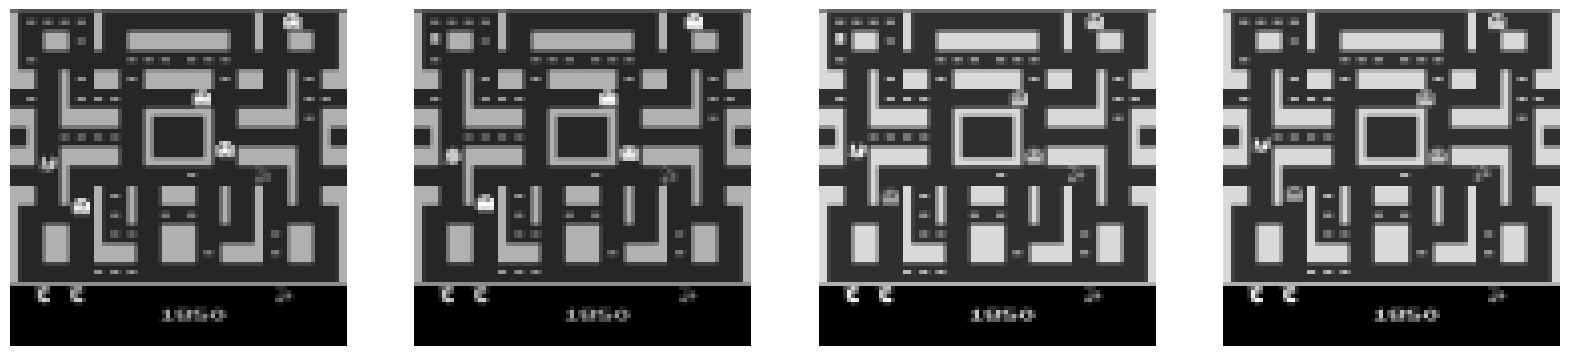

tensor(58.2297, device='cuda:0')


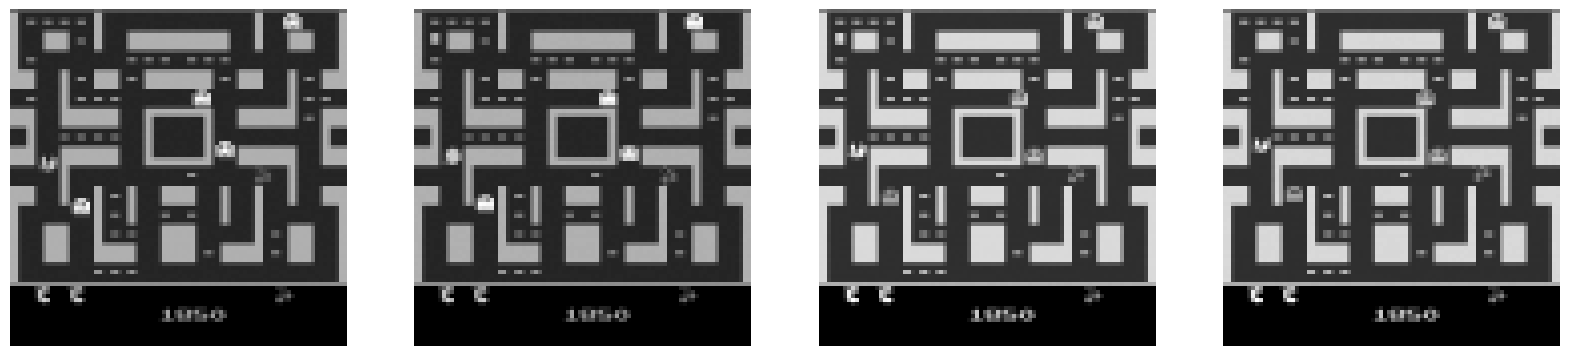

tensor(58.2297, device='cuda:0')
tensor(250.3822, device='cuda:0')


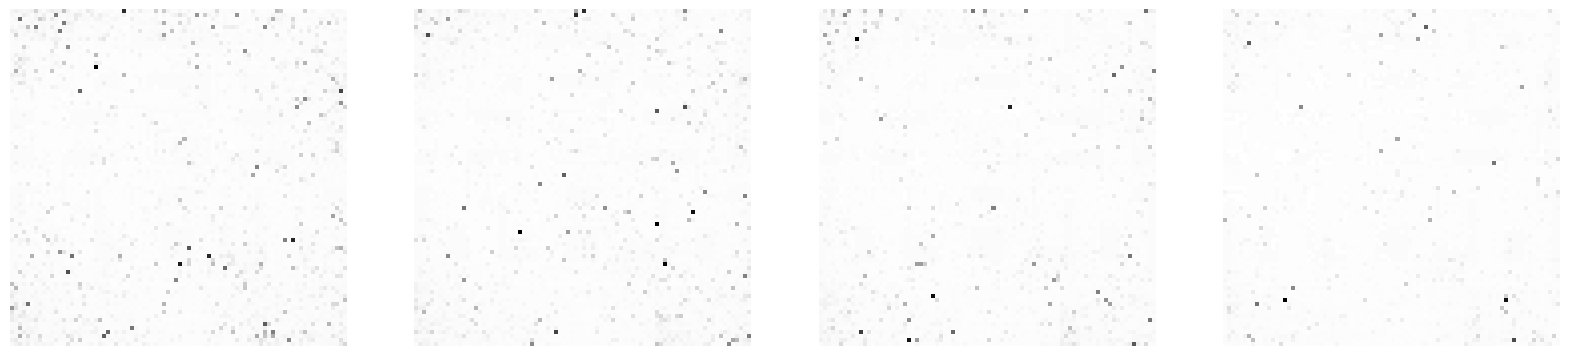

MAX: 255.00001525878906


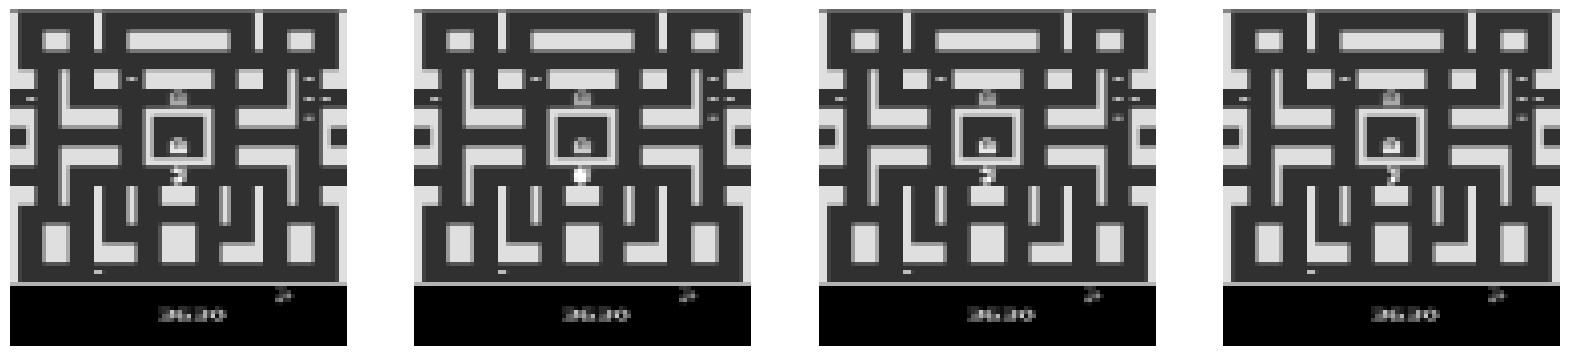

tensor(56.1493, device='cuda:0')


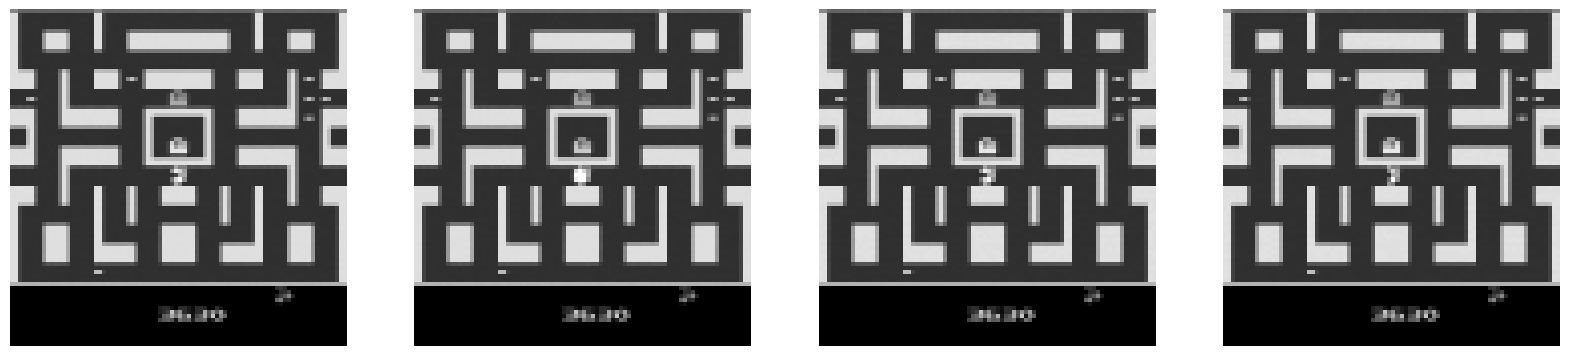

tensor(56.1493, device='cuda:0')
tensor(218.1660, device='cuda:0')


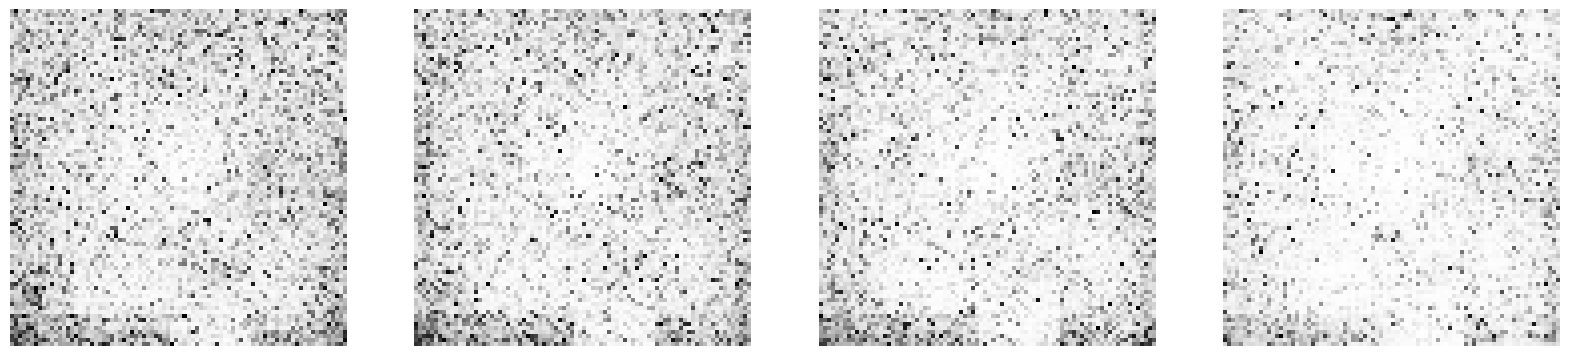

MAX: 255.0


[EVAL] Total score: 3640.0: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it]

1113


In [5]:
cfg_path = "/home/yw3809/Projects/policy_distillation/src/configs/MsPacmanNoFrameskip-v4/dqn4_da.yaml"
viz(cfg_path)

  0%|          | 0/1 [00:00<?, ?it/s]

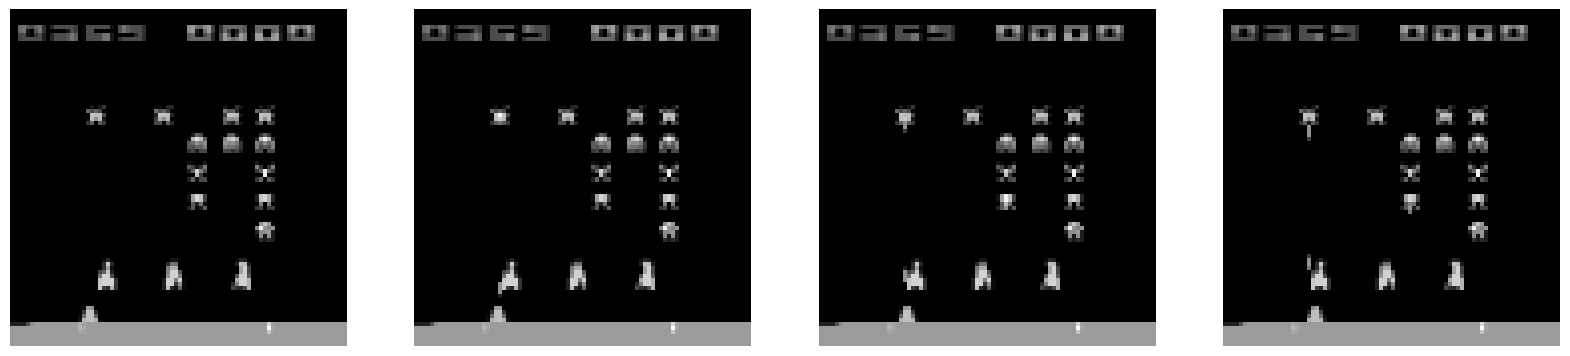

tensor(9.6885, device='cuda:0')


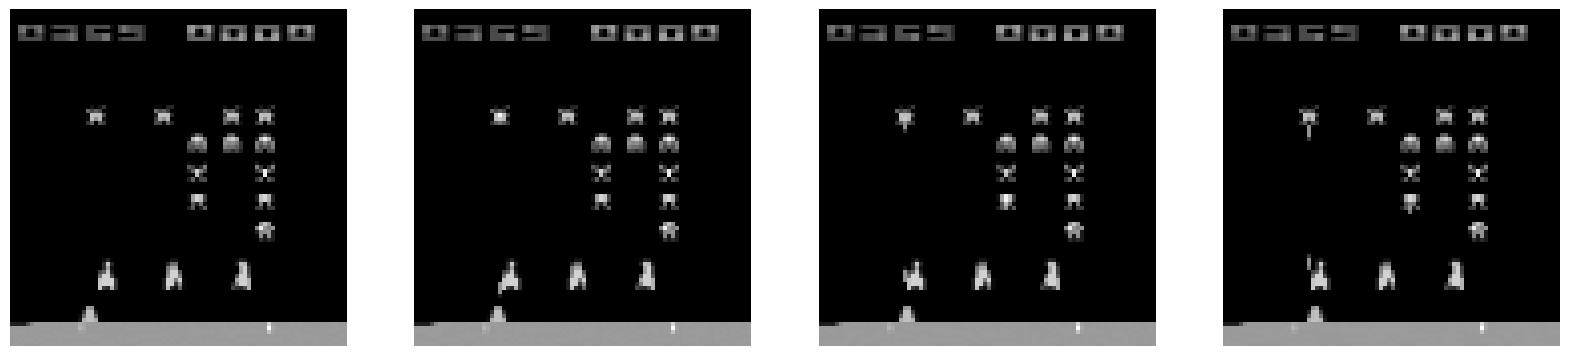

tensor(9.6884, device='cuda:0')
tensor(246.3137, device='cuda:0')


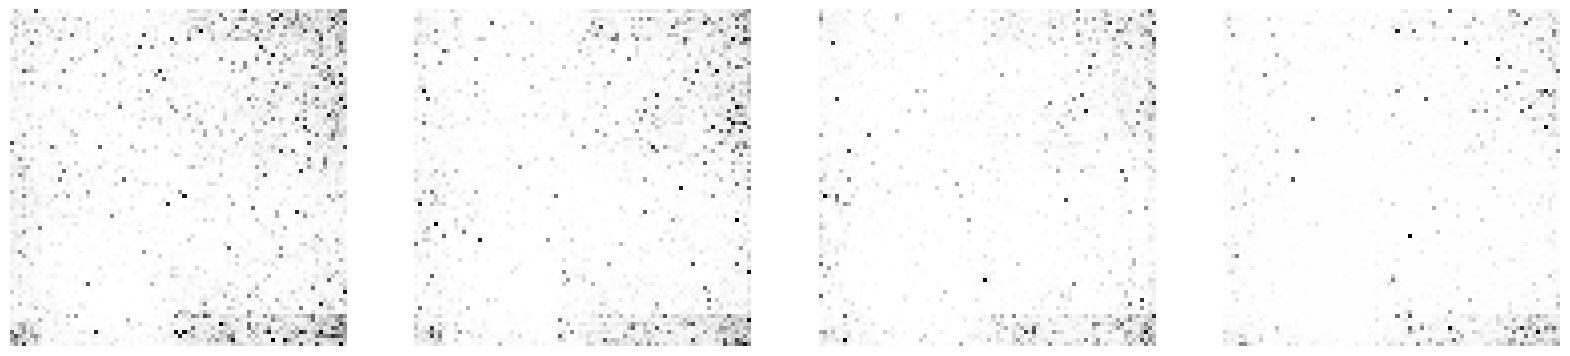

MAX: 255.0


[EVAL] Total score: 385.0: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

619


In [6]:
cfg_path = "/home/yw3809/Projects/policy_distillation/src/configs/SpaceInvadersNoFrameskip-v4/dqn4_da.yaml"
viz(cfg_path)

  0%|          | 0/1 [00:00<?, ?it/s]

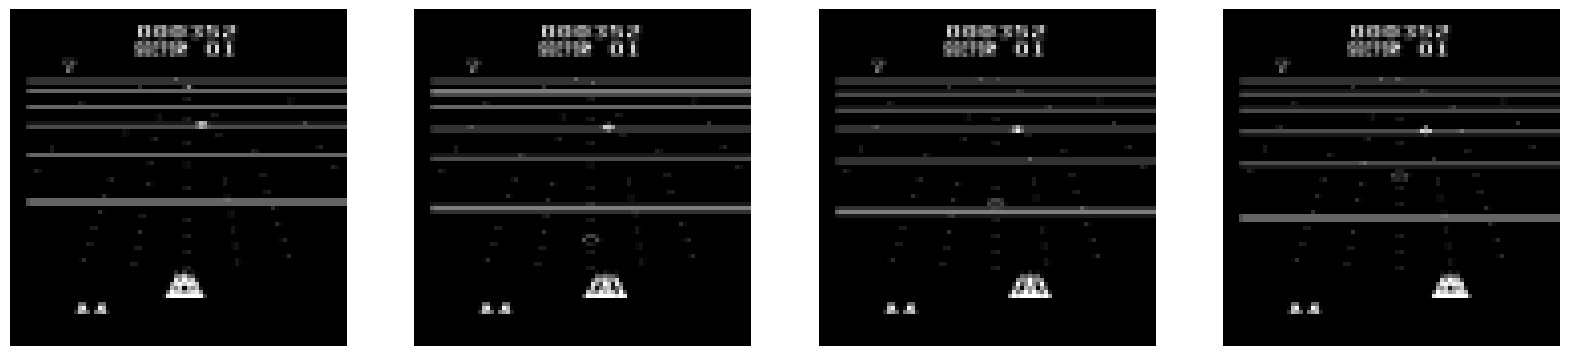

tensor(9.4423, device='cuda:0')


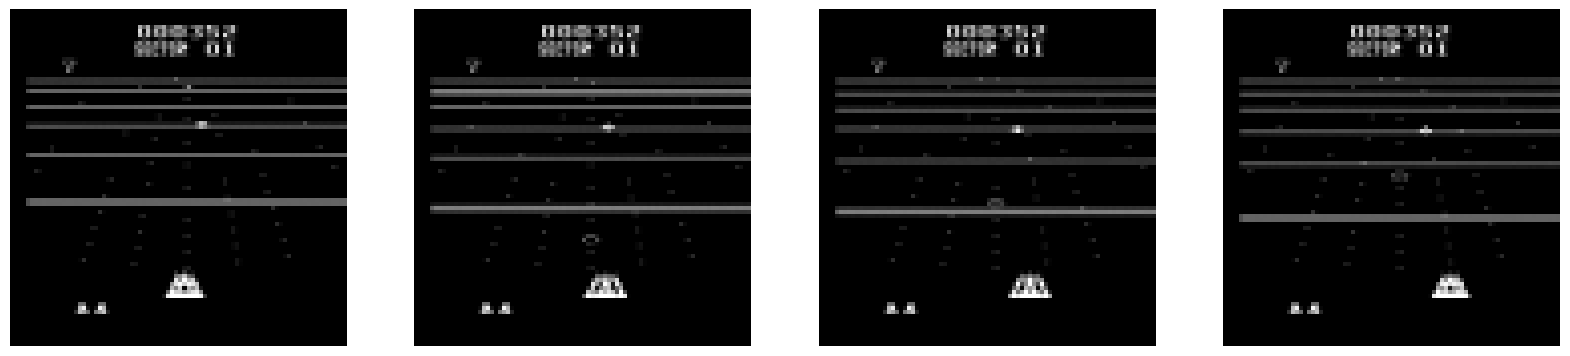

tensor(9.4423, device='cuda:0')
tensor(141.1532, device='cuda:0')


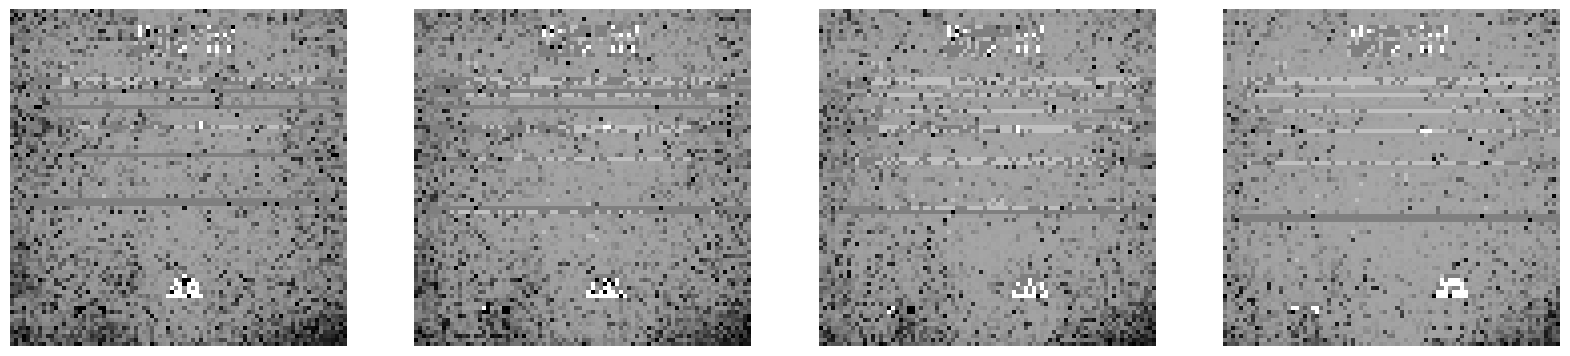

MAX: 255.0


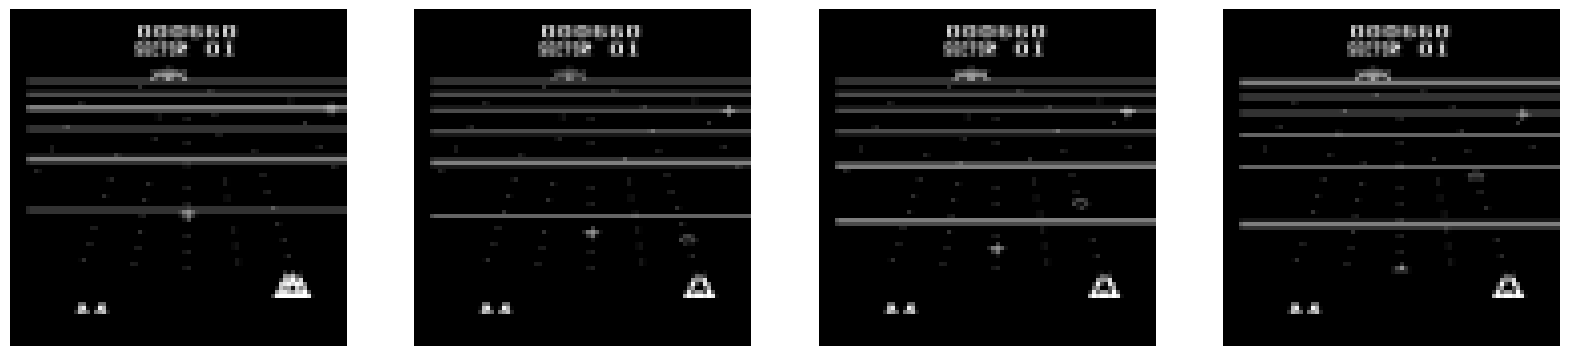

tensor(9.9065, device='cuda:0')


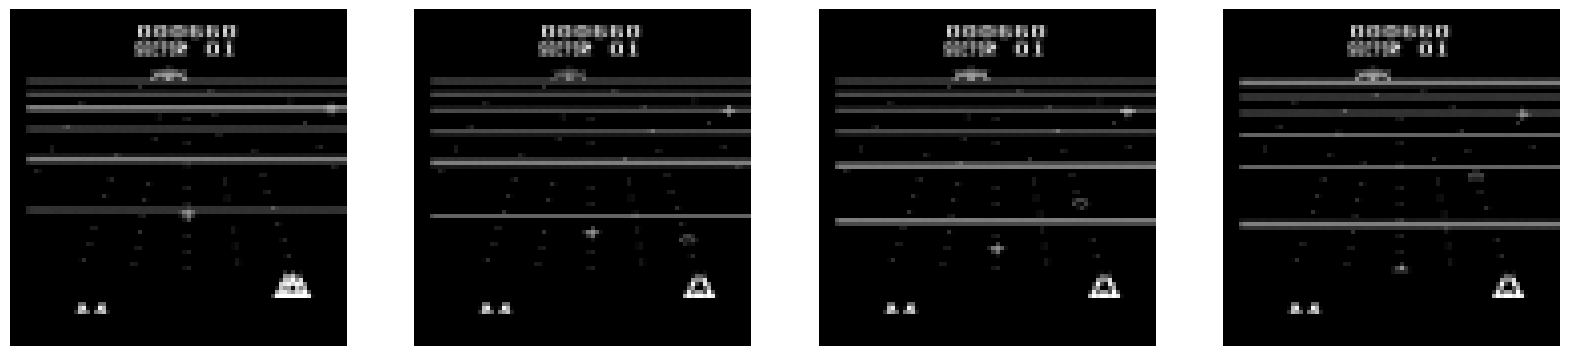

tensor(9.9065, device='cuda:0')
tensor(83.7610, device='cuda:0')


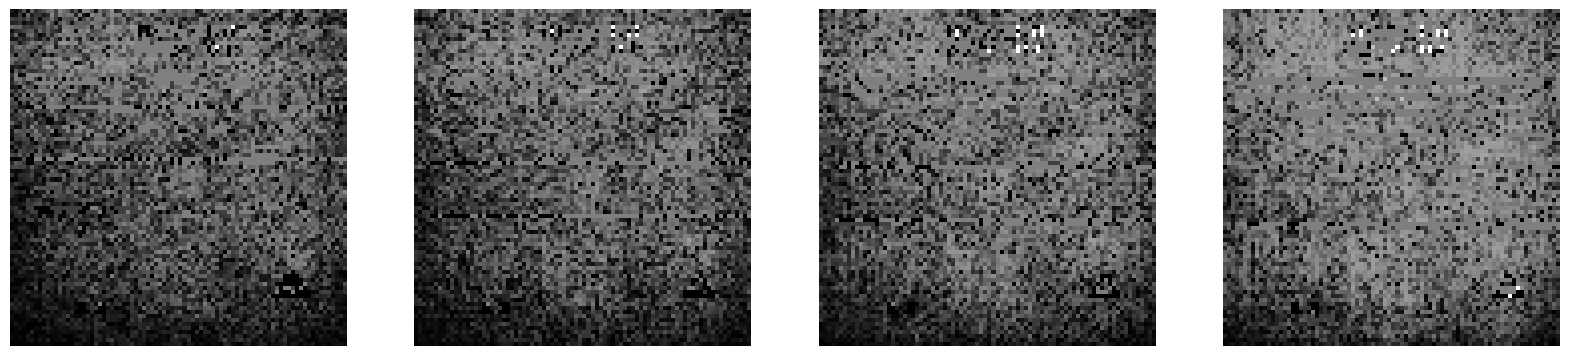

MAX: 255.0


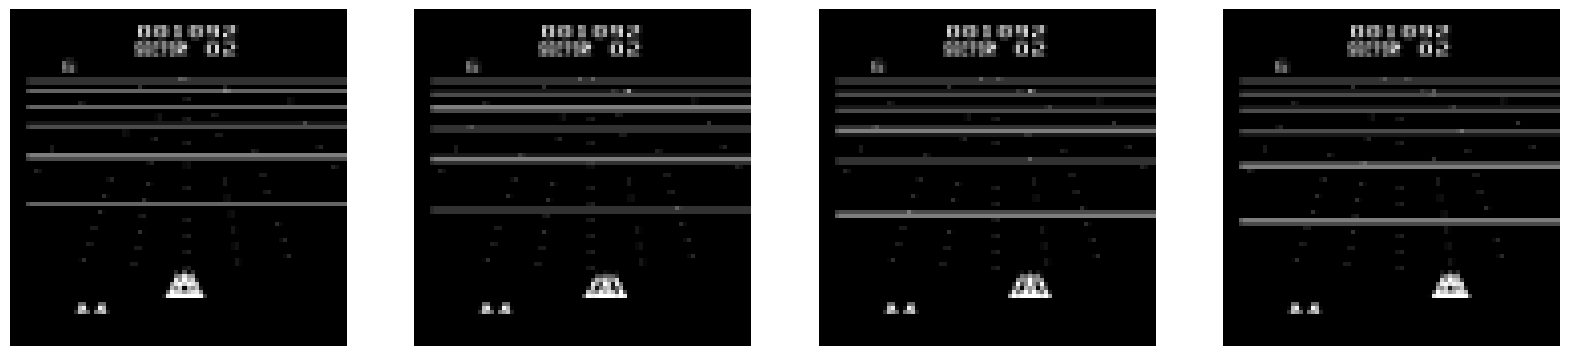

tensor(9.8684, device='cuda:0')


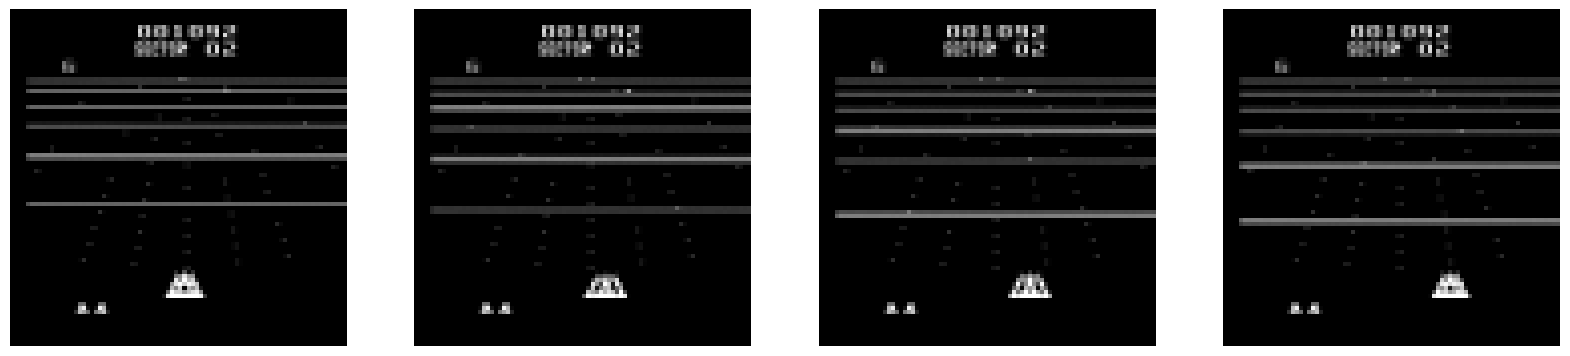

tensor(9.8684, device='cuda:0')
tensor(128.9456, device='cuda:0')


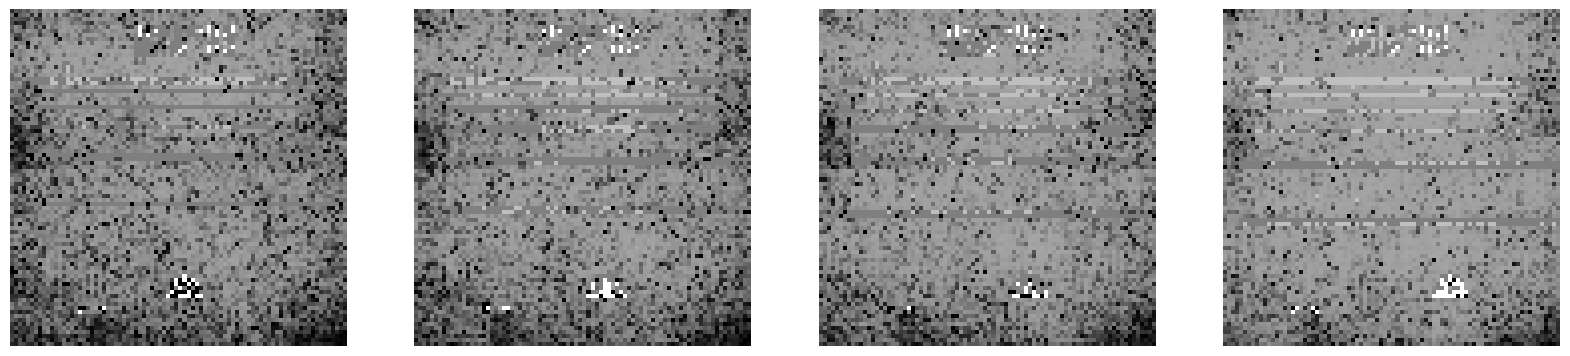

MAX: 255.0


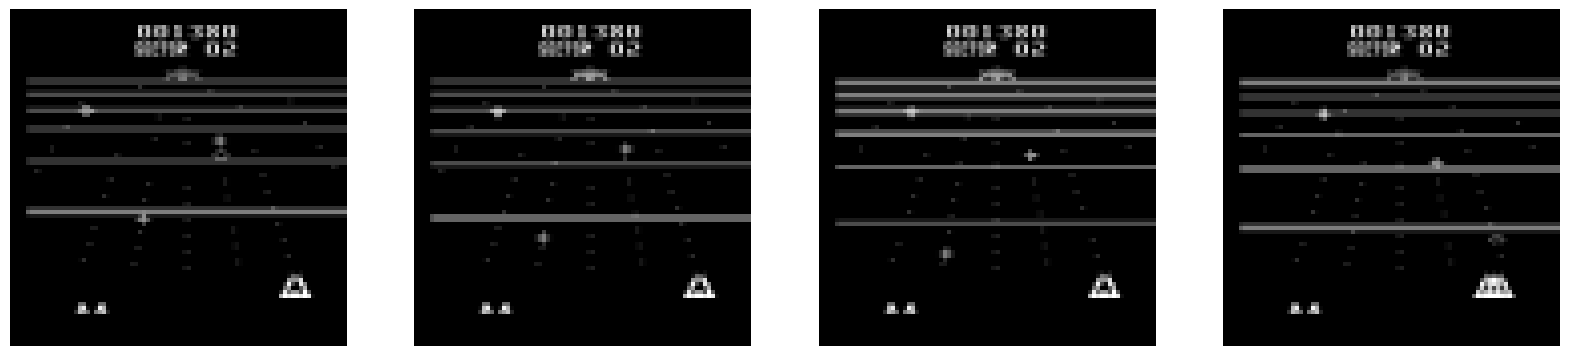

tensor(10.3201, device='cuda:0')


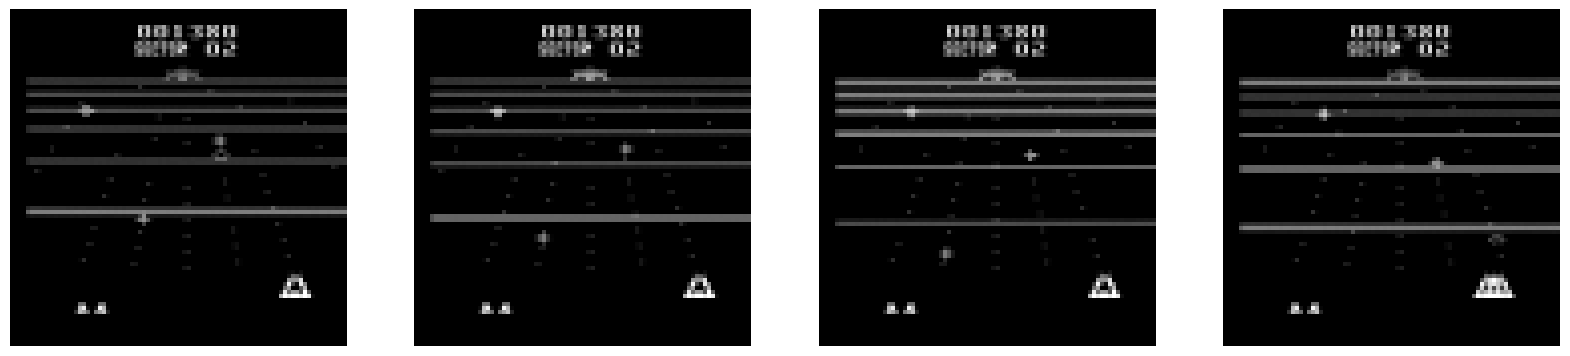

tensor(10.3201, device='cuda:0')
tensor(80.9915, device='cuda:0')


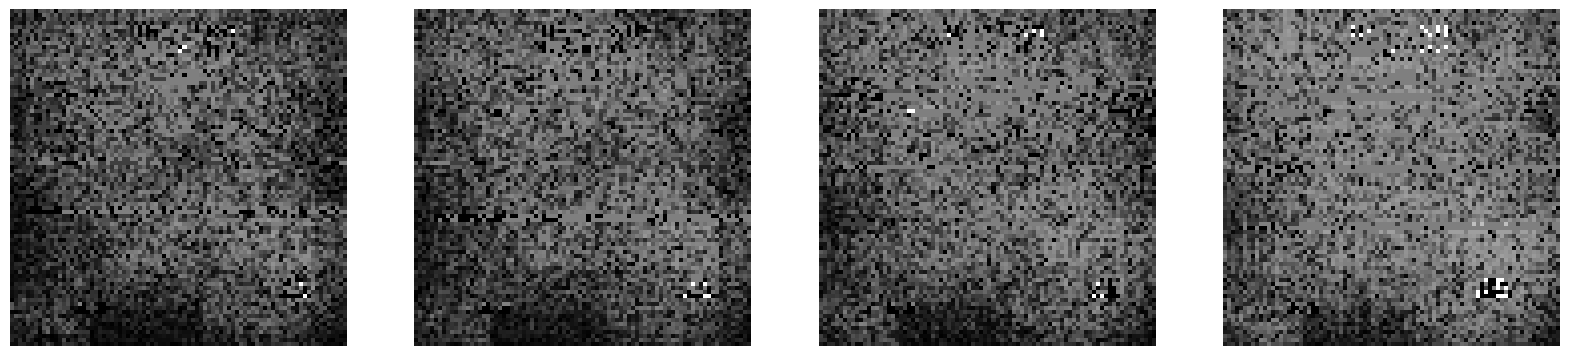

MAX: 255.0


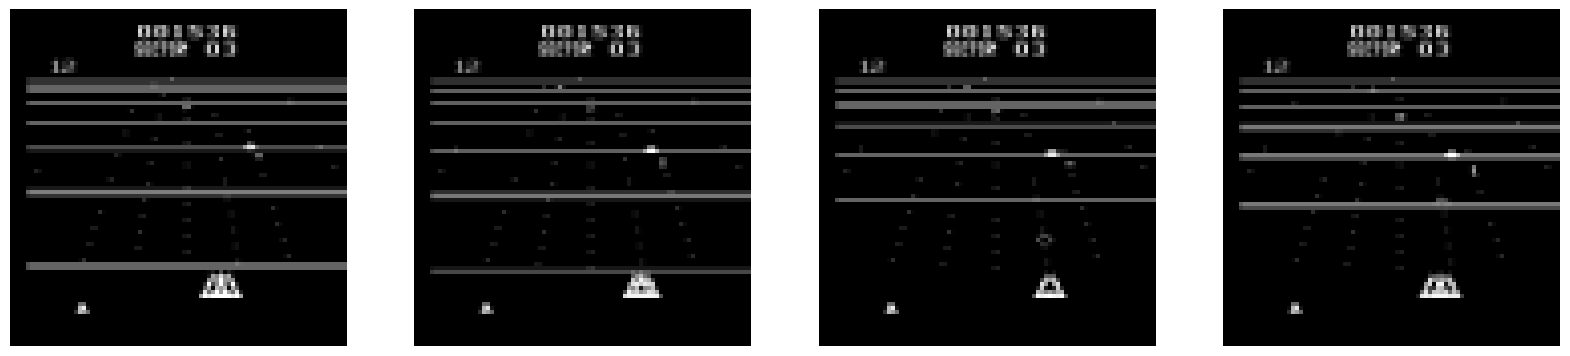

tensor(10.4424, device='cuda:0')


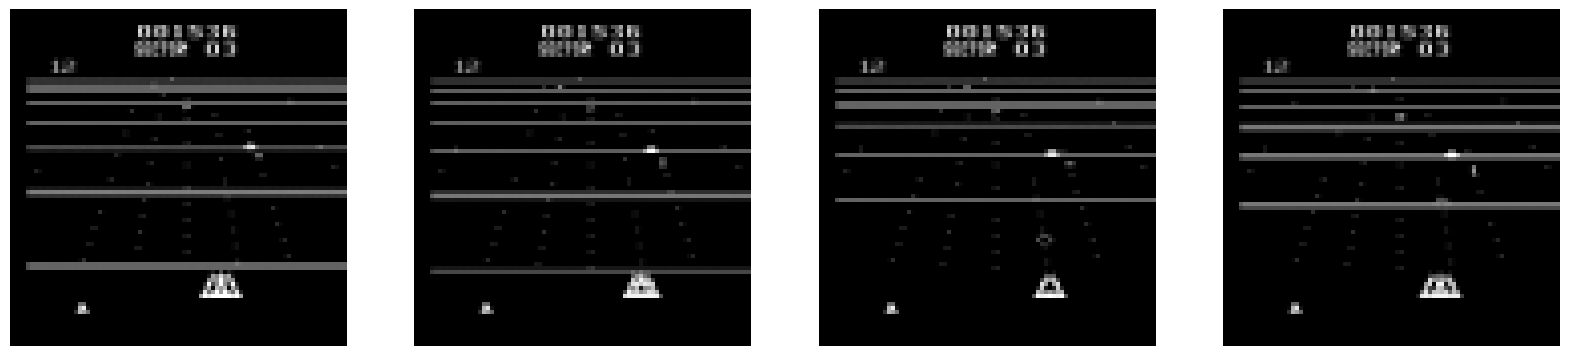

tensor(10.4424, device='cuda:0')
tensor(150.3911, device='cuda:0')


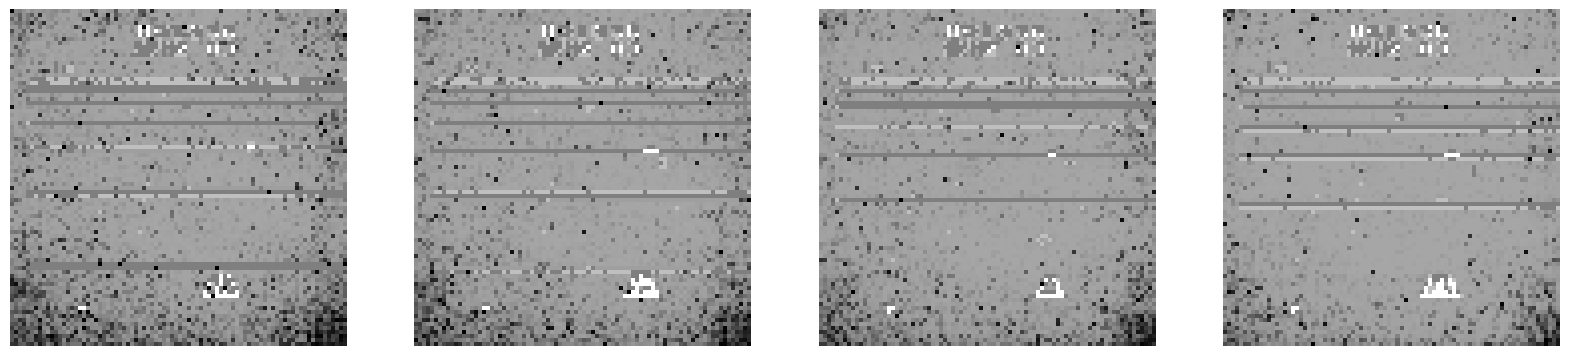

MAX: 255.0


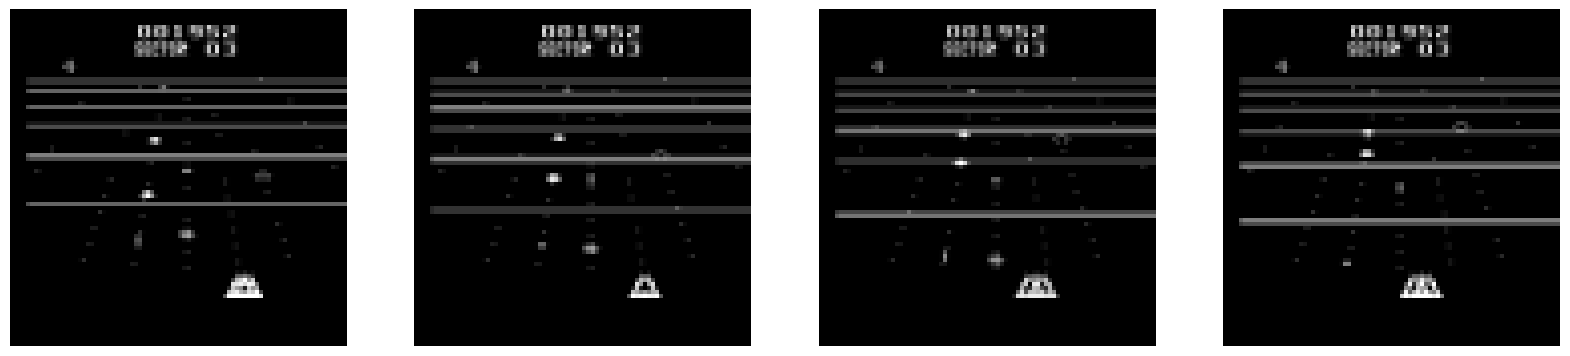

tensor(9.8154, device='cuda:0')


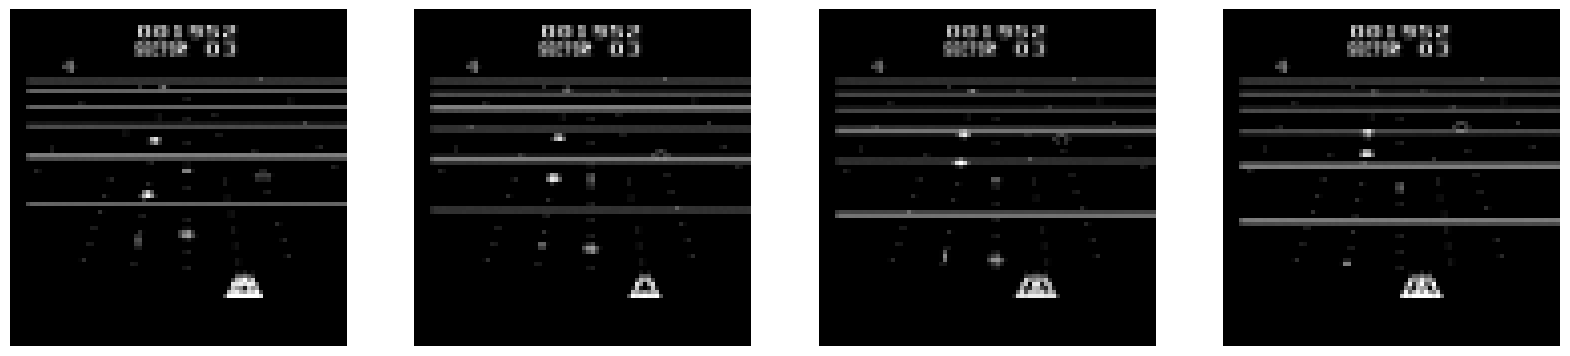

tensor(9.8154, device='cuda:0')
tensor(158.9004, device='cuda:0')


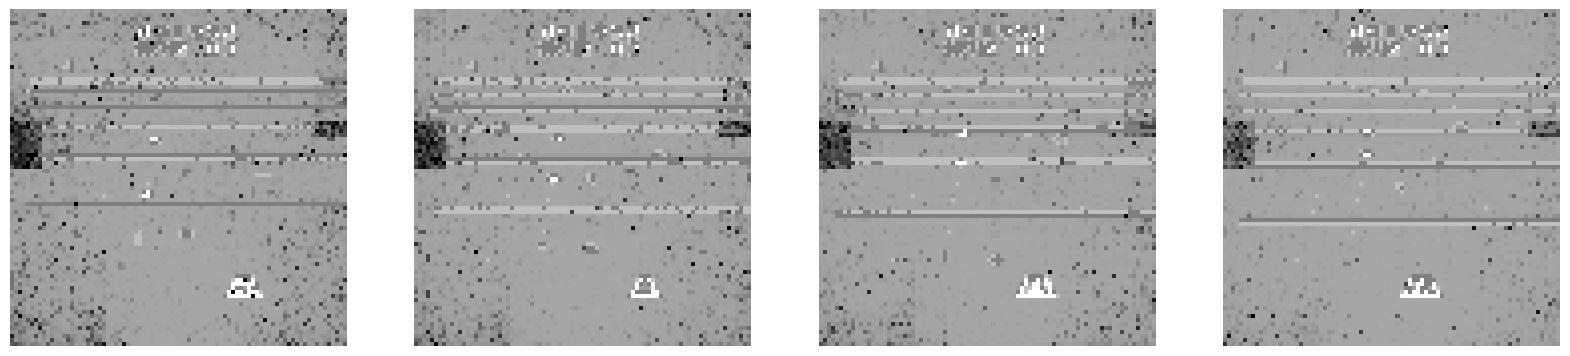

MAX: 255.0


[EVAL] Total score: 1952.0: 100%|██████████| 1/1 [00:07<00:00,  7.37s/it]

3071


In [7]:
cfg_path = "/home/yw3809/Projects/policy_distillation/src/configs/BeamRiderNoFrameskip-v4/dqn4_da_00001.yaml"
viz(cfg_path)